In [11]:
import time
import timeit
from enum import Enum
import math
import matplotlib.pyplot as plt
import numpy as np

# one step binomial
from enum import Enum
import math

#from intro import opTiming

class PayoffType(str, Enum):
    Call = 'Call'
    Put = 'Put'
    
def cnorm(x):
    return (1.0 + math.erf(x / math.sqrt(2.0))) / 2.0

def bsPrice(S, r, vol, T, strike, payoffType):
    fwd = S * math.exp(r * T)
    stdev = vol * math.sqrt(T)
    d1 = math.log(fwd / strike) / stdev + stdev / 2
    d2 = d1 - stdev
    if payoffType == PayoffType.Call:
        return math.exp(-r * T) * (fwd * cnorm(d1) - cnorm(d2) * strike)
    elif payoffType == PayoffType.Put:
        return math.exp(-r * T) * (strike * cnorm(-d2) - cnorm(-d1) * fwd)
    elif payoffType == PayoffType.BinaryCall:
        return math.exp(-r * T) * cnorm(d1)
    elif payoffType == PayoffType.BinaryPut:
        return math.exp(-r * T) * (1-cnorm(-d1))
    else:
        raise Exception("not supported payoff type", payoffType)

class EuropeanOption():
    def __init__(self, expiry, strike, payoffType):
        self.expiry = expiry
        self.strike = strike
        self.payoffType = payoffType
    def payoff(self, S):
        if self.payoffType == PayoffType.Call:
            return max(S - self.strike, 0)
        elif self.payoffType == PayoffType.Put:
            return max(self.strike - S, 0)
        elif self.payoffType == PayoffType.BinaryCall:
            if S > self.strike:
                return 1.0
            else:
                return 0.0
        elif self.payoffType == PayoffType.BinaryPut:
            if S < self.strike:
                return 1.0
            else:
                return 0.0
        else:
            raise Exception("payoffType not supported: ", self.payoffType)
    def valueAtNode(self, t, S, continuation):
        if continuation == None:
            return self.payoff(S)
        else:
            return continuation

# CRR Binomial Tree Model

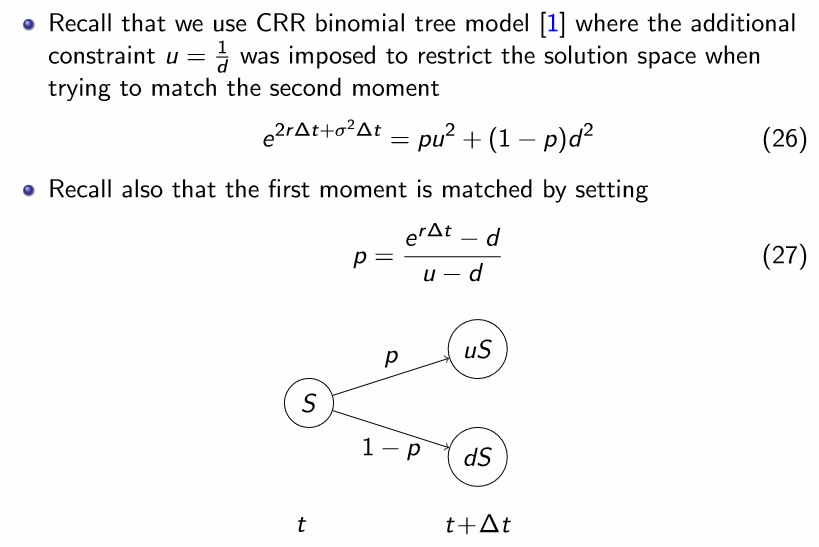
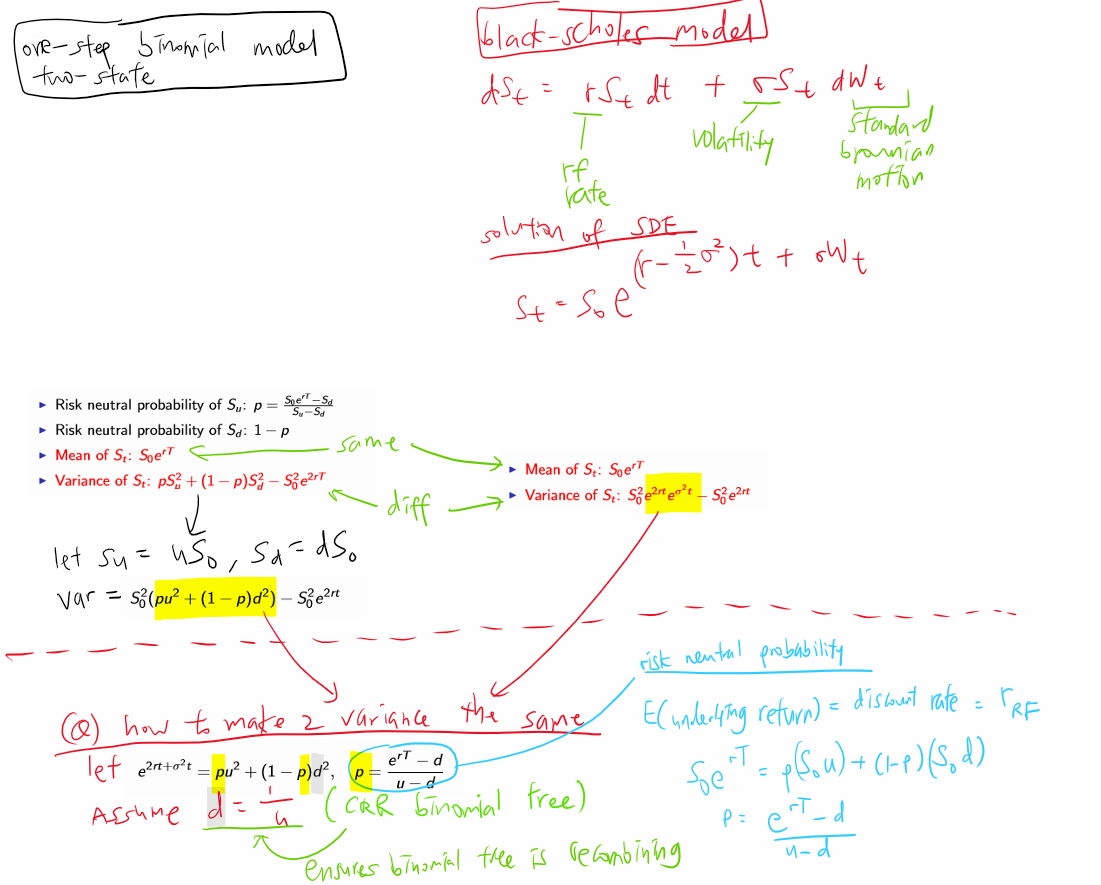
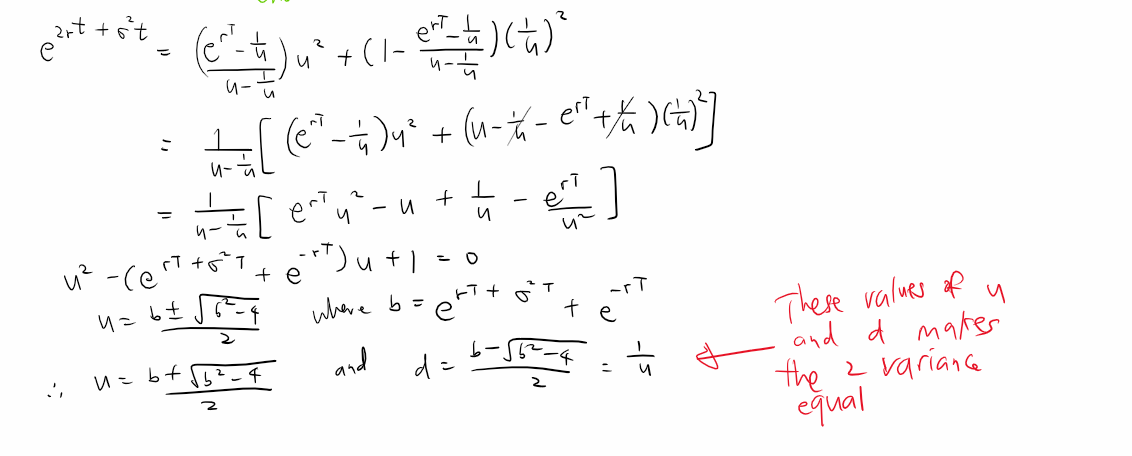

In [1]:
# the 'calib' input used different model to calc u,d,p
def binomialPricer(S, r, vol, trade, n, calib):
    t = trade.expiry / n
    (u, d, p) = calib(r, vol, t)
    # set up the last time slice, there are n+1 nodes at the last time slice
    vs = [trade.payoff(S * u ** (n - i) * d ** i) for i in range(n + 1)]
    # iterate backward
    for i in range(n - 1, -1, -1):
        # calculate the value of each node at time slide i, there are i nodes
        for j in range(i + 1):
            nodeS = S * u ** (i - j) * d ** j
            continuation = math.exp(-r * t) * (vs[j] * p + vs[j + 1] * (1 - p))
            vs[j] = trade.valueAtNode(t * i, nodeS, continuation)
    return vs[0]

# Assumption for underlying price for binomial tree
- up factor (u)
- down factor (d)
- risk-neutral probability (p)

## Cox-Ross-Rubinstein (CRR) Calibration (crrCalib):
- This is one of the most commonly used models.
- The up and down factors are symmetrical (i.e., d = 1/u).
- The risk-neutral probability p is derived from the up factor and the risk-free rate.
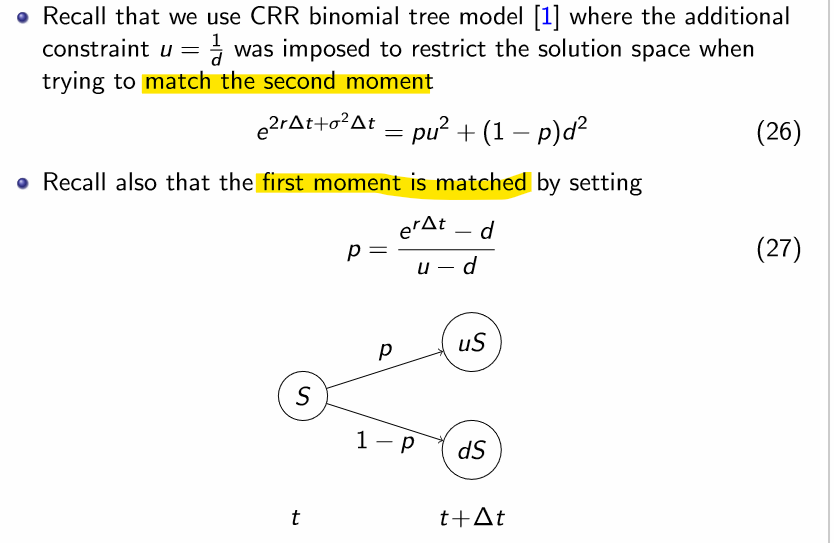

## Jarrow-Rudd Risk-Neutral (JRRN) Calibration (jrrnCalib):
- Assumes that the expected return of the underlying asset is the risk-free rate (r).
- The up and down factors are calculated based on the risk-free rate, the volatility, and the time step.
- The risk-neutral probability p is derived from the up and down factors and the risk-free rate.
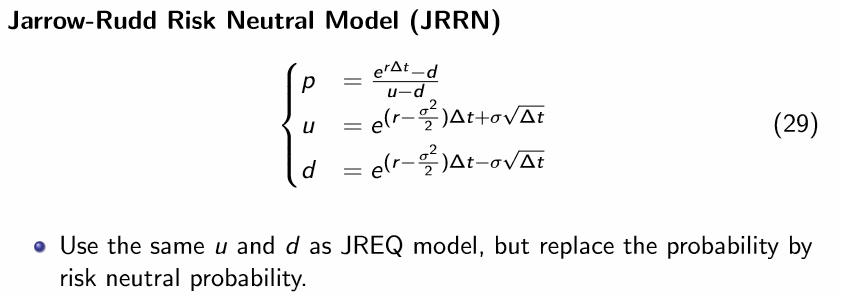

## Jarrow-Rudd Equal Probabilities (JREQ) Calibration (jreqCalib):
- Similar to the JRRN calibration, it calculates the up and down factors using the risk-free rate and volatility.
- The model assumes that the probabilities of moving up or down are equal, hence p = 1/2.
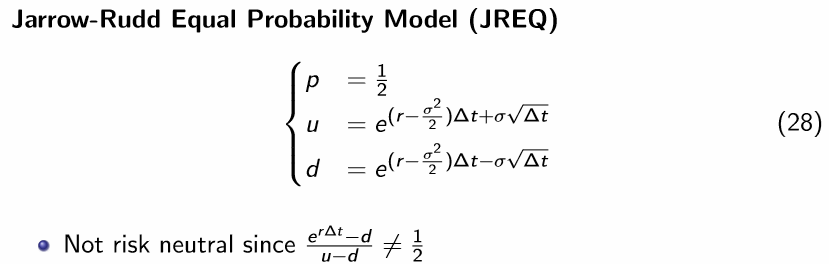

## Tian Calibration (tianCalib):
- A more complex model that ensures that the tree recombines and the distribution of the underlying asset price converges to the lognormal distribution as the number of steps increases.
- The up and down factors are derived from the volatility and the risk-free rate, with a more complex formula that includes the term v, which is the exponential of volatility squared times the time step.
- The risk-neutral probability p is again derived from the up and down factors and the risk-free rate.
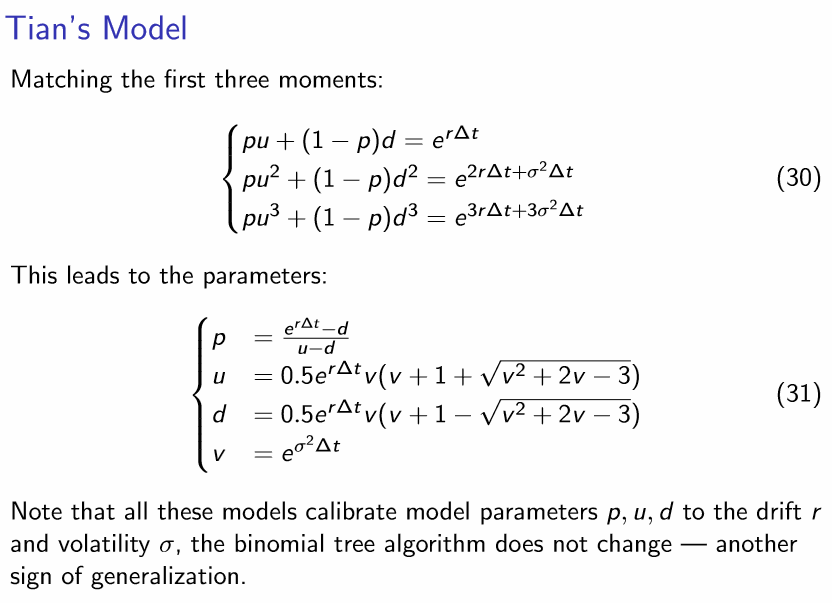

In [2]:
def crrCalib(r, vol, t):
    b = math.exp(vol * vol * t + r * t) + math.exp(-r * t)
    u = (b + math.sqrt(b * b - 4)) / 2
    p = (math.exp(r * t) - (1 / u)) / (u - 1 / u)
    return (u, 1/u, p)

def jrrnCalib(r, vol, t):
    u = math.exp((r - vol * vol / 2) * t + vol * math.sqrt(t))
    d = math.exp((r - vol * vol / 2) * t - vol * math.sqrt(t))
    p = (math.exp(r * t) - d) / (u - d)
    return (u, d, p)

def jreqCalib(r, vol, t):
    u = math.exp((r - vol * vol / 2) * t + vol * math.sqrt(t))
    d = math.exp((r - vol * vol / 2) * t - vol * math.sqrt(t))
    return (u, d, 1/2)

def tianCalib(r, vol, t):
    v = math.exp(vol * vol * t)
    u = 0.5 * math.exp(r * t) * v * (v + 1 + math.sqrt(v*v + 2*v - 3))
    d = 0.5 * math.exp(r * t) * v * (v + 1 - math.sqrt(v*v + 2*v - 3))
    p = (math.exp(r * t) - d) / (u - d)
    return (u, d, p)

In [14]:
def testBTrees():
    opt = EuropeanOption(1, 105, PayoffType.Call)
    S, r, vol = 100, 0.01, 0.2

    bsprc = bsPrice(S, r, vol, opt.expiry, opt.strike, opt.payoffType)
    print("bsPrice = \t ", bsprc)
    n = 300

    crrErrs = [math.log(abs(binomialPricer(S, r, vol, opt, i, crrCalib) - bsprc)) for i in range(1, n)]
    jrrnErrs = [math.log(abs(binomialPricer(S, r, vol, opt, i, jrrnCalib) - bsprc)) for i in range(1, n)]
    jreqErrs = [math.log(abs(binomialPricer(S, r, vol, opt, i, jreqCalib) - bsprc)) for i in range(1, n)]
    tianErrs = [math.log(abs(binomialPricer(S, r, vol, opt, i, tianCalib) - bsprc)) for i in range(1, n)]

    plt.plot(range(1, n), crrErrs, label="crr")
    plt.plot(range(1, n), jrrnErrs, label="jrrn")
    plt.plot(range(1, n), jreqErrs, label="jreq")
    plt.plot(range(1, n), tianErrs, label="tian")
    plt.legend()
    plt.show()

bsPrice = 	  6.297254539086019


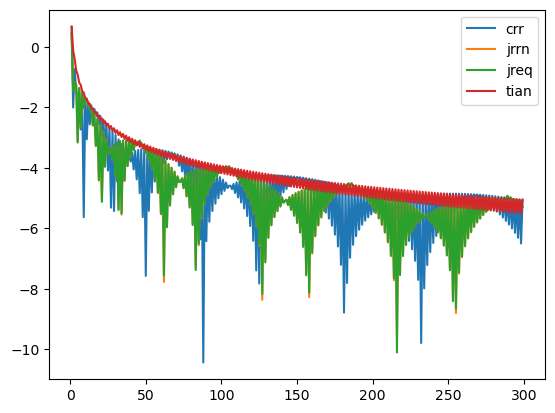

In [16]:
testBTrees()